In [ ]:

import torch
import os

print("="*70)
print("🔥 TPU CONFIGURATION")
print("="*70)

# Install TPU dependencies
!pip install -q cloud-tpu-client torch-xla

# Import TPU libraries
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl

# Check TPU
print(f"\nPyTorch Version: {torch.__version__}")
print(f"TPU Available: {xm.xla_device() is not None}")

# Get TPU device
device = xm.xla_device()
print(f"TPU Device: {device}")

print("\n✅ TPU configured!")

🔥 TPU CONFIGURATION
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.4/120.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 14.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
google-cloud-storage 2.19.0 requires google-api-core<3.0.0dev,>=2.15.0, but you have google-api-core 1.34.1 which is incompatible.


/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or



PyTorch Version: 2.8.0+cpu


/tmp/ipython-input-3125701000.py:23: DeprecationWarning: Use torch_xla.device instead
  print(f"TPU Available: {xm.xla_device() is not None}")
/tmp/ipython-input-3125701000.py:26: DeprecationWarning: Use torch_xla.device instead
  device = xm.xla_device()


TPU Available: True
TPU Device: xla:0

✅ TPU configured!


In [2]:
# ============================================================
# LOAD DATA
# ============================================================

from google.colab import drive
import pickle
import sys

# Mount Drive
drive.mount('/content/drive')

# Load dataset
dataset_path = '/content/drive/MyDrive/language_models/mega_word_dataset.pkl'

print(f"📂 Loading dataset from Drive...")
print(f"   Path: {dataset_path}")

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)

print(f"\n✅ Dataset loaded!")
print(f"   Vocabulary: {dataset['vocab_size']:,}")
print(f"   Total words: {len(dataset['encoded']):,}")
print(f"   Expected sequences: {len(dataset['encoded']) // 50:,}")

Mounted at /content/drive
📂 Loading dataset from Drive...
   Path: /content/drive/MyDrive/language_models/mega_word_dataset.pkl

✅ Dataset loaded!
   Vocabulary: 20,000
   Total words: 206,130,222
   Expected sequences: 4,122,604


In [3]:
# ============================================================
# MODEL DEFINITION (copied directly to avoid import issues)
# ============================================================

import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=4,
                 dim_feedforward=1024, dropout=0.2):
        super(TransformerModel, self).__init__()

        assert d_model % nhead == 0

        self.d_model = d_model
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)

        self._init_weights()

    def _init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()
        self.fc_out.weight.data.uniform_(-initrange, initrange)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask

    def forward(self, x):
        batch_size, seq_len = x.size()

        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)

        mask = self.generate_square_subsequent_mask(seq_len).to(x.device)
        x = self.transformer_encoder(x, mask=mask)
        x = x.contiguous().view(-1, self.d_model)
        output = self.fc_out(x)

        return output

print("✅ TransformerModel defined!")

✅ TransformerModel defined!


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class WordDataset(Dataset):
    def __init__(self, encoded_data, seq_length):
        self.data = encoded_data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) // self.seq_length

    def __getitem__(self, idx):
        start = idx * self.seq_length
        end = start + self.seq_length

        x = self.data[start:end]
        y = self.data[start + 1:end + 1]

        return torch.LongTensor(x), torch.LongTensor(y)

# Split data
split_idx = int(0.9 * len(dataset['encoded']))
train_data = dataset['encoded'][:split_idx]
val_data = dataset['encoded'][split_idx:]

# Create datasets
train_dataset = WordDataset(train_data, 50)
val_dataset = WordDataset(val_data, 50)

# LARGER batch size for TPU!
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, drop_last=True)

print(f"✅ Data ready!")
print(f"   Train batches: {len(train_loader):,}")
print(f"   Val batches: {len(val_loader):,}")

✅ Data ready!
   Train batches: 7,246
   Val batches: 805


In [5]:
# ============================================================
# CREATE MODEL FOR TPU
# ============================================================

# Create model
model = TransformerModel(
    vocab_size=dataset['vocab_size'],
    d_model=512,
    nhead=8,
    num_layers=6,
    dim_feedforward=2048,
    dropout=0.2
).to(device)

params = sum(p.numel() for p in model.parameters())

print(f"🧠 Model created on TPU!")
print(f"   Parameters: {params:,}")
print(f"   Device: {device}")

🧠 Model created on TPU!
   Parameters: 39,414,304
   Device: xla:0


In [9]:
# ============================================================
# TRAINING CONFIGURATION
# ============================================================

CONFIG = {
    'model_type': 'transformer',
    'epochs': 30,
    'batch_size': 512,  # Large batch for TPU!
    'seq_length': 50,
    'learning_rate': 0.0003,

    # Model architecture (LARGER than before!)
    'd_model': 512,
    'nhead': 8,
    'num_layers': 6,
    'dim_feedforward': 2048,
    'dropout': 0.3,
}

print("🎛️  CONFIGURATION")
print("="*70)
for key, value in CONFIG.items():
    print(f"{key:20s}: {value}")
print("="*70)



🎛️  CONFIGURATION
model_type          : transformer
epochs              : 30
batch_size          : 512
seq_length          : 50
learning_rate       : 0.0003
d_model             : 512
nhead               : 8
num_layers          : 6
dim_feedforward     : 2048
dropout             : 0.3


In [11]:
# ============================================================
# TPU TRAINING WITH SCHEDULER
# ============================================================

import torch.optim as optim
from tqdm.notebook import tqdm
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
)

train_losses = []
val_losses = []
best_val_loss = float('inf')

print("\n🚀 STARTING TPU TRAINING WITH ADAPTIVE LR")
print("="*70)

start_time = time.time()

for epoch in range(1, CONFIG['epochs'] + 1):
    # Training
    model.train()
    total_train_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{CONFIG['epochs']}")

    for batch_idx, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)

        loss = criterion(output, y.view(-1))
        loss.backward()

        xm.optimizer_step(optimizer)
        xm.mark_step()

        total_train_loss += loss.item()

        if batch_idx % 100 == 0:
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y.view(-1))
            total_val_loss += loss.item()

    val_loss = total_val_loss / len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)


    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    if epoch > 1 and current_lr != optimizer.param_groups[0]['lr']:
      print(f"   📉 Learning rate reduced to: {current_lr}")

    elapsed = time.time() - start_time

    print(f"\n📊 Epoch {epoch}/{CONFIG['epochs']}")
    print(f"   Train: {train_loss:.4f}")
    print(f"   Val:   {val_loss:.4f}")
    print(f"   Time:  {elapsed/60:.1f} min")

    # Check current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    if current_lr != CONFIG['learning_rate']:
        print(f"   📉 LR adjusted to: {current_lr}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': CONFIG
        }, 'transformer_balanced_best.pth')
        print(f"   ✅ New best: {val_loss:.4f}")

print(f"\n🎉 TRAINING COMPLETE!")
print(f"⏱️  Time: {(time.time()-start_time)/3600:.2f} hours")
print(f"🏆 Best: {best_val_loss:.4f}")


🚀 STARTING TPU TRAINING WITH ADAPTIVE LR


Epoch 1/30:   0%|          | 0/7246 [00:00<?, ?it/s]

/tmp/ipython-input-405967907.py:46: DeprecationWarning: Use torch_xla.sync instead
  xm.mark_step()



📊 Epoch 1/30
   Train: 3.3228
   Val:   4.2191
   Time:  15.4 min
   ✅ New best: 4.2191


Epoch 2/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 2/30
   Train: 3.2457
   Val:   4.1699
   Time:  30.3 min
   ✅ New best: 4.1699


Epoch 3/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 3/30
   Train: 3.2006
   Val:   4.1424
   Time:  45.4 min
   ✅ New best: 4.1424


Epoch 4/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 4/30
   Train: 3.1699
   Val:   4.1181
   Time:  60.4 min
   ✅ New best: 4.1181


Epoch 5/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 5/30
   Train: 3.1477
   Val:   4.1003
   Time:  75.4 min
   ✅ New best: 4.1003


Epoch 6/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 6/30
   Train: 3.1307
   Val:   4.0832
   Time:  90.4 min
   ✅ New best: 4.0832


Epoch 7/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 7/30
   Train: 3.1171
   Val:   4.0798
   Time:  105.6 min
   ✅ New best: 4.0798


Epoch 8/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 8/30
   Train: 3.1061
   Val:   4.0768
   Time:  120.6 min
   ✅ New best: 4.0768


Epoch 9/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 9/30
   Train: 3.0967
   Val:   4.0878
   Time:  135.5 min


Epoch 10/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 10/30
   Train: 3.0887
   Val:   4.0569
   Time:  150.5 min
   ✅ New best: 4.0569


Epoch 11/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 11/30
   Train: 3.0819
   Val:   4.0649
   Time:  165.5 min


Epoch 12/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 12/30
   Train: 3.0758
   Val:   4.0647
   Time:  180.4 min


Epoch 13/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 13/30
   Train: 3.0704
   Val:   4.0596
   Time:  195.6 min


Epoch 14/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 14/30
   Train: 3.0655
   Val:   4.0584
   Time:  210.5 min
   📉 LR adjusted to: 0.00015


Epoch 15/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 15/30
   Train: 3.0235
   Val:   4.0312
   Time:  225.3 min
   📉 LR adjusted to: 0.00015
   ✅ New best: 4.0312


Epoch 16/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 16/30
   Train: 3.0119
   Val:   4.0344
   Time:  240.5 min
   📉 LR adjusted to: 0.00015


Epoch 17/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 17/30
   Train: 3.0068
   Val:   4.0197
   Time:  255.7 min
   📉 LR adjusted to: 0.00015
   ✅ New best: 4.0197


Epoch 18/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 18/30
   Train: 3.0033
   Val:   4.0232
   Time:  270.6 min
   📉 LR adjusted to: 0.00015


Epoch 19/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 19/30
   Train: 3.0003
   Val:   4.0164
   Time:  285.8 min
   📉 LR adjusted to: 0.00015
   ✅ New best: 4.0164


Epoch 20/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 20/30
   Train: 2.9977
   Val:   4.0156
   Time:  300.9 min
   📉 LR adjusted to: 0.00015
   ✅ New best: 4.0156


Epoch 21/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 21/30
   Train: 2.9955
   Val:   4.0187
   Time:  316.0 min
   📉 LR adjusted to: 0.00015


Epoch 22/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 22/30
   Train: 2.9934
   Val:   4.0365
   Time:  331.2 min
   📉 LR adjusted to: 0.00015


Epoch 23/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 23/30
   Train: 2.9915
   Val:   4.0285
   Time:  346.3 min
   📉 LR adjusted to: 0.00015


Epoch 24/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 24/30
   Train: 2.9898
   Val:   4.0260
   Time:  361.5 min
   📉 LR adjusted to: 7.5e-05


Epoch 25/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 25/30
   Train: 2.9693
   Val:   4.0100
   Time:  376.7 min
   📉 LR adjusted to: 7.5e-05
   ✅ New best: 4.0100


Epoch 26/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 26/30
   Train: 2.9640
   Val:   4.0152
   Time:  391.7 min
   📉 LR adjusted to: 7.5e-05


Epoch 27/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 27/30
   Train: 2.9617
   Val:   4.0183
   Time:  406.8 min
   📉 LR adjusted to: 7.5e-05


Epoch 28/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 28/30
   Train: 2.9600
   Val:   4.0197
   Time:  421.7 min
   📉 LR adjusted to: 7.5e-05


Epoch 29/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 29/30
   Train: 2.9586
   Val:   4.0176
   Time:  436.9 min
   📉 LR adjusted to: 3.75e-05


Epoch 30/30:   0%|          | 0/7246 [00:00<?, ?it/s]


📊 Epoch 30/30
   Train: 2.9484
   Val:   4.0115
   Time:  452.1 min
   📉 LR adjusted to: 3.75e-05

🎉 TRAINING COMPLETE!
⏱️  Time: 7.53 hours
🏆 Best: 4.0100


In [12]:
# ============================================================
# TEST GENERATION: See what your model learned!
# ============================================================

def generate_sample(model, dataset_dict, device, start_text="Money is", length=100):
    """Generate text using trained model."""
    model.eval()

    words = start_text.lower().split()
    unk_idx = dataset_dict['word_to_idx'].get('<UNK>', 1)

    input_seq = [dataset_dict['word_to_idx'].get(w, unk_idx) for w in words]
    input_seq = torch.LongTensor([input_seq]).to(device)

    generated = words.copy()

    with torch.no_grad():
        for _ in range(length):
            output = model(input_seq)
            probs = torch.softmax(output[-1] / 0.8, dim=0)
            next_idx = torch.multinomial(probs, 1).item()

            next_word = dataset_dict['idx_to_word'][next_idx]
            generated.append(next_word)

            next_tensor = torch.LongTensor([[next_idx]]).to(device)
            input_seq = torch.cat([input_seq, next_tensor], dim=1)

            if input_seq.size(1) > 50:
                input_seq = input_seq[:, -50:]

    return ' '.join(generated)

# Load best model
checkpoint = torch.load('transformer_balanced_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("🎯 SAMPLE GENERATIONS FROM BALANCED CORPUS MODEL")
print("="*70)

test_prompts = [
    "Money is",
    "Investing in",
    "The stock market",
    "Financial freedom means",
    "To build wealth",
    "The best investment strategy"
]

for prompt in test_prompts:
    print(f"\n💬 Prompt: '{prompt}'")
    print("-"*70)
    text = generate_sample(model, dataset, device, prompt, length=80)
    print(text)

print("\n" + "="*70)

🎯 SAMPLE GENERATIONS FROM BALANCED CORPUS MODEL

💬 Prompt: 'Money is'
----------------------------------------------------------------------
money is really a little more like to <UNK> the money . " " you know , listen to your money , you know , " <UNK> said . " you can ' t run a competitive game . " his key of his responsibility now involves avoiding financial volatility . " " you can ' t have the financial situation , but you can ' t get the handle on the stock . if it ' s going to be a

💬 Prompt: 'Investing in'
----------------------------------------------------------------------
investing in new products , including <UNK> , <UNK> ; and the manufacture and distribution of components in certain markets . also , sales of <UNK> products and services mentioned herein are used to make <UNK> product products and services available to consumers on a wholesale basis . the company believes that sales of <UNK> products and services are useful to investors and analysts , as well as provide ad

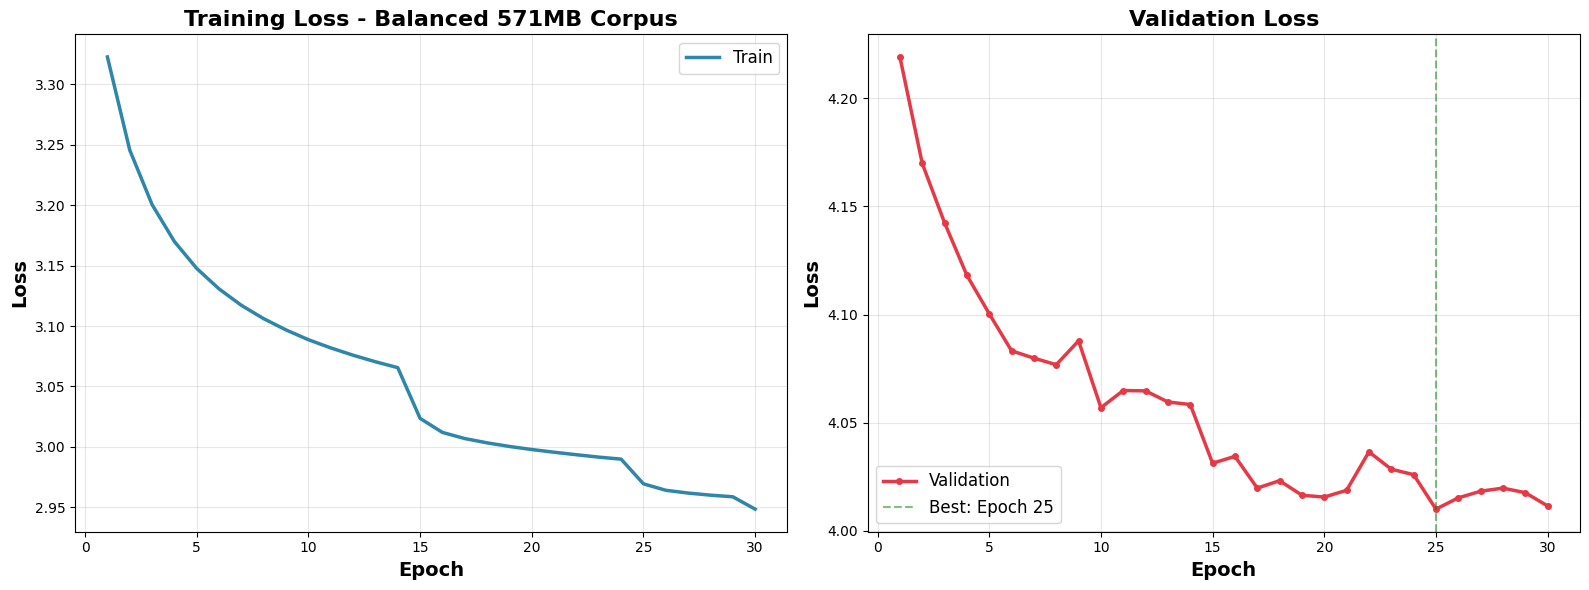


📊 TRAINING STATISTICS:
   Best val loss: 4.0100 (epoch 25)
   Final val loss: 4.0115
   Improvement: 0.2077

🏆 COMPARISON TO PREVIOUS EXPERIMENTS:
   Char LSTM (640KB):          1.47 loss
   Word Trans (103MB classical): 5.32 loss
   Word Trans (571MB balanced):  4.0100 loss

⚠️  Needs more work


In [13]:
# ============================================================
# VISUALIZE RESULTS
# ============================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

epochs = range(1, len(train_losses) + 1)

# Training loss
axes[0].plot(epochs, train_losses, linewidth=2.5, color='#2E86AB', label='Train')
axes[0].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=14, fontweight='bold')
axes[0].set_title('Training Loss - Balanced 571MB Corpus', fontsize=16, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=12)

# Validation loss
axes[1].plot(epochs, val_losses, linewidth=2.5, color='#E63946', marker='o', markersize=4, label='Validation')
best_epoch = val_losses.index(min(val_losses)) + 1
axes[1].axvline(best_epoch, color='green', linestyle='--', alpha=0.5, label=f'Best: Epoch {best_epoch}')
axes[1].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=14, fontweight='bold')
axes[1].set_title('Validation Loss', fontsize=16, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=12)

plt.tight_layout()
plt.savefig('balanced_training_curves.png', dpi=300)
plt.show()

print("\n📊 TRAINING STATISTICS:")
print(f"   Best val loss: {min(val_losses):.4f} (epoch {best_epoch})")
print(f"   Final val loss: {val_losses[-1]:.4f}")
print(f"   Improvement: {val_losses[0] - val_losses[-1]:.4f}")

# Compare to previous results
print("\n🏆 COMPARISON TO PREVIOUS EXPERIMENTS:")
print(f"   Char LSTM (640KB):          1.47 loss")
print(f"   Word Trans (103MB classical): 5.32 loss")
print(f"   Word Trans (571MB balanced):  {min(val_losses):.4f} loss")

if min(val_losses) < 2.5:
    print(f"\n✅ SUCCESS! Target achieved (<2.5 loss)!")
elif min(val_losses) < 3.5:
    print(f"\n✅ GOOD! Significant improvement!")
else:
    print(f"\n⚠️  Needs more work")